In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Transform from PIL imgs (28, 28)[0 - 255] to normalized tensor [1, 28, 28][0.0 - 1.0]  
train_set = torchvision.datasets.FashionMNIST(root="../data/raw", train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root="../data/raw", train=False, download=True, transform=transform)

In [3]:
# Creating batches to optimize the memory of image processing
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [4]:
# Detecting if a GPU is available:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used: {torch.cuda.get_device_name(0)}") if device == "cuda" else print("No GPU available: Using CPU")

Device used: NVIDIA GeForce RTX 5080


In [5]:
# Defining the NN dimensions:
input_dim = 784 # 28x28 images in a row vector
z_dim = 20 # Latent space size
h_dim = 200 # Number of hide layers of NN.

# Defining the NN architecture:
class AE(torch.nn.Module):
    def __init__(self, input_dim, z_dim, h_dim):
        super().__init__()
        
        # Encoding:
        self.common = torch.nn.Linear(input_dim, h_dim) # Fully connected NN: (784, 200)
        self.encoded = torch.nn.Linear(h_dim, z_dim) # (200, 20)

        # Decoding:
        self.l1 = torch.nn.Linear(z_dim, h_dim) # (20, 200)
        self.decoded = torch.nn.Linear(h_dim, input_dim) # (200, 784) again...

    def encoder(self, x):
        common = torch.nn.functional.relu(self.common(x))
        mu = self.encoded(common)

        return mu
    
    def decoder(self, z):
        out = torch.nn.functional.relu(self.l1(z))
        out = torch.sigmoid(self.decoded(out))

        return out
    
    def forward(self, x):
        mu = self.encoder(x)
        out = self.decoder(mu)

        return out, mu

In [6]:
# Instanciating the model:
model = AE(input_dim, z_dim, h_dim).to(device) # Send to process on GPU|CPU
lr = 0.00025 # Learning rate for optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam is an advanced version of gradient descent

In [7]:
# Creating a Validation Subset:
originals = [] # Set of images for validation
idx = 0 # Numerical label of the target category.
nClasses = len(test_set.classes) # Number of categories in dataset

for img, label in test_set:
    if label == idx: # If the image belongs to the target category
        originals.append(img) 
        idx += 1

    if idx == nClasses:
        break # Exit condition in case the number of categories is surpassed

# Defining function to plot the images:
def plot_imgs():
    reconstructed = []
    
    for idx in range(10):
        with torch.no_grad(): # Not calculate gradient in this execution
            img = originals[idx].reshape((1, input_dim)) # Reshape the input validation image
            out, _ = model(img.to(device))

            reconstructed.append(out)

    imgs = originals + reconstructed

    plt.figure(figsize=(10, 2), dpi=50)

    for i in range(nClasses * 2):
        ax = plt.subplot(2, 10, i + 1)
        img = (imgs[i].detach().cpu().numpy())

        plt.imshow(img.reshape(28, 28), cmap="binary")
        plt.xticks([])
        plt.yticks([])

    plt.show()

At epoch 0 total loss = 814.4581496744792


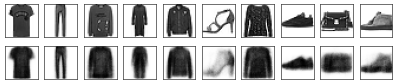

At epoch 1 total loss = 447.8233313476562


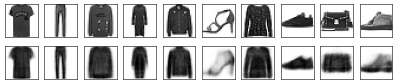

At epoch 2 total loss = 390.19430294596356


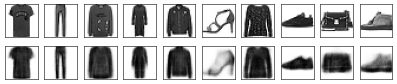

At epoch 3 total loss = 359.60168430989586


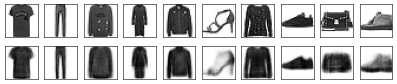

At epoch 4 total loss = 339.6158717122396


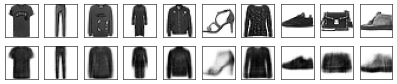

At epoch 5 total loss = 326.01150819498696


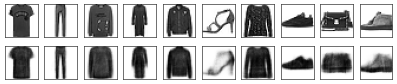

At epoch 6 total loss = 316.38797674967446


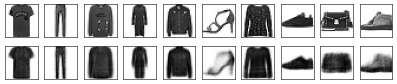

At epoch 7 total loss = 308.9024641438802


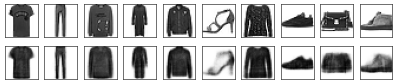

At epoch 8 total loss = 302.9613496826172


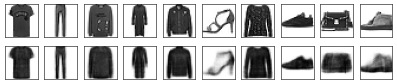

At epoch 9 total loss = 297.95067171223957


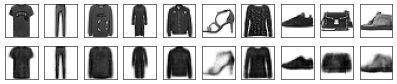

In [8]:
# Training the model:
nEpochs = 10 # Number of epochs

for epoch in range(nEpochs):
    tloss = 0 # Error sum

    for imgs, labels in train_loader:
        imgs = imgs.to(device).view(-1, input_dim)
        out, mu = model(imgs)
        loss = ((out - imgs) ** 2).sum()
        optimizer.zero_grad() # Trinity_1
        loss.backward() # Trininy_2
        optimizer.step() # Trinity_3.
        tloss += loss.item()

    print(f"At epoch {epoch} total loss = {tloss / len(train_loader)}")
    plot_imgs()

In [9]:
scripted = torch.jit.script(model)
scripted.save("../models/AEFashion.pt")